In [1]:
# TODO:
# - FIx values on pie /
# - Preprocess data for punc/pos charts
# - Either merge or create scatter for frequent words
# - Scatter or split into news/entertainment (spellcheck)

In [2]:
from tfn.preprocess import Dataset, check_spelling

import os
os.chdir('../')

import numpy as np
import pandas as pd

#VISUALISATION
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import seaborn as sns

import re
from collections import Counter
import seaborn as sns
import string
import spacy
from spacy.lemmatizer import Lemmatizer

import urllib.parse as urlparse

In [3]:
data = Dataset('twitter', strip_digits=False)

X_train, X_test = data.X_train, data.X_test
X = np.array(X_train + X_test)

y_train, y_test = data.y_train, data.y_test
y = np.array(y_train + y_test)

In [4]:
### PLOT SETUP ###

COLOR_0 = '#00203F'
COLOR_1 = '#ADEFD1'
# COLOR_2 = '#46A894'

COLOR_NEG = '#87EBA8'
COLOR_NEU = '#EEEEEE'
COLOR_POS = '#F28268'
COLOR_OTH = '#7389AE'

TITLE_SIZE = 24
SUBTITLE_SIZE = 20
TICK_SIZE = 16

plt.style.use('seaborn-paper')

rcParams['font.size'] = TICK_SIZE

In [5]:
num_0 = y[y == 0].size
num_1 = y[y == 1].size

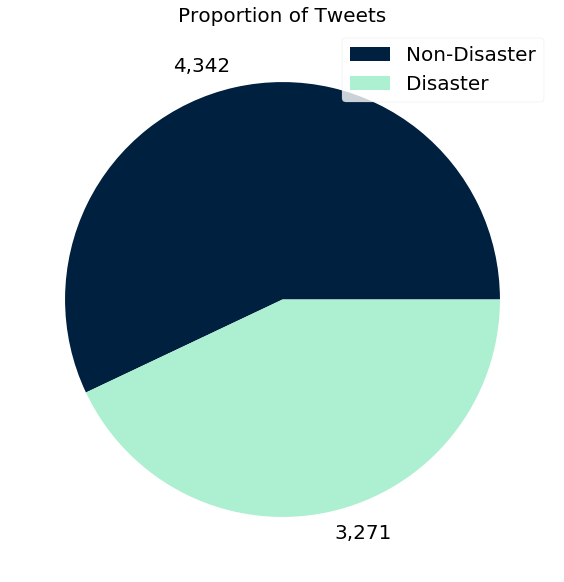

In [6]:
fig1, ax = plt.subplots(figsize=(10,10))

ax.pie((num_0, num_1), labels=[f"{num_0:,d}", f"{num_1:,d}"],
       colors=[COLOR_0, COLOR_1], textprops={'fontsize': SUBTITLE_SIZE})


ax.set_title('Proportion of Tweets', fontsize=SUBTITLE_SIZE)
ax.legend(labels=['Non-Disaster', 'Disaster'], fontsize=SUBTITLE_SIZE)

# Most Frequent Words

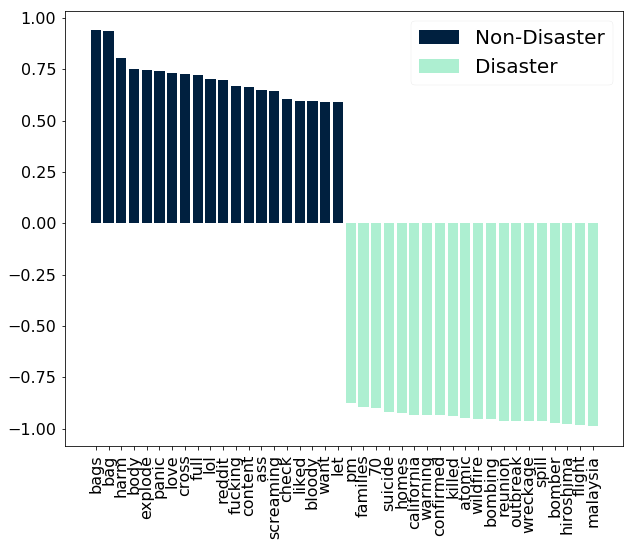

In [7]:
all_words_0 = []
all_words_1 = []
for i, _ in enumerate(X):
    if y[i] == 0:
        all_words_0 += X[i]
    elif y[i] == 1:
        all_words_1 += X[i]
    else:
        print('Hey, something weird\'s happening...')
        

c0 = list(Counter(all_words_0).items())
c0.sort(key=lambda x: x[1], reverse=True)

c1 = list(Counter(all_words_1).items())
c1.sort(key=lambda x: x[1], reverse=True)

c0_df = pd.DataFrame(c0)
c1_df = pd.DataFrame(c1)
freq_df = pd.merge(c0_df, c1_df, on=0)
freq_df['tot'] = freq_df['1_x'] + freq_df['1_y']
freq_df.sort_values('tot', ascending=False, inplace=True)
freq_df.columns = ['word', '0_freq', '1_freq', 'freq']

freq_df['0_freq_norm'], freq_df['1_freq_norm'], freq_df['freq_norm'] = freq_df['0_freq']/num_0, freq_df['1_freq']/num_1, freq_df['freq']/(num_0+num_1)

freq_df['diff %'] = (freq_df['0_freq_norm'] - freq_df['1_freq_norm']) / freq_df[['0_freq_norm', '1_freq_norm']].sum(1)
freq_diff_above_100 = freq_df[['word', 'diff %']][freq_df['freq_norm'] >= 0.005].sort_values('diff %', ascending=False)

top_bottom = 20
freq_top_bottom = pd.concat([freq_diff_above_100.head(top_bottom), freq_diff_above_100.tail(top_bottom)])

ax.bar(freq_top_bottom['word'], freq_top_bottom['diff %'])

fig2, ax = plt.subplots(figsize=(10,8), sharey=True)
# width = 0.4
# N = np.arange(top_freq_df.shape[0])

# ax.bar(freq_top_bottom['diff %'],)
# # ax.bar(N + width/2, freq_top_bottom['1_freq'], width=width, color=COLOR_1, label='Disaster Tweets')

ax.bar(freq_top_bottom['word'], freq_top_bottom['diff %'].apply(lambda x: x if x>0 else 0), 
       color=COLOR_0)
ax.bar(freq_top_bottom['word'], freq_top_bottom['diff %'].apply(lambda x: x if x<0 else 0), 
       color=COLOR_1)
ax.tick_params(axis='x', rotation=90, labelsize=TICK_SIZE)
ax.tick_params(axis='y', labelsize=TICK_SIZE)

ax.legend(labels=['Non-Disaster', 'Disaster'], fontsize=SUBTITLE_SIZE)

# #Maybe change colour based on sentiment of word?

In [8]:
# from gensim.models import Word2Vec
# from sklearn import cluster as c

# freq_20 = freq_df[freq_df['freq'] >= 50]
# word2vec = Word2Vec(X, min_count=2)
# freq_20['embedding'] = freq_20['word'].apply(lambda x: word2vec.wv.get_vector(x))

In [9]:
# cluster = c.KMeans(n_clusters=6)

# emb_array = np.empty((freq_20.shape[0], 100))
# to_emb = freq_20['embedding'].values
# for i in range(emb_array.shape[0]):
#     emb_array[i] = to_emb[i]

# output = cluster.fit_predict(emb_array)
# freq_20['cluster'] = output

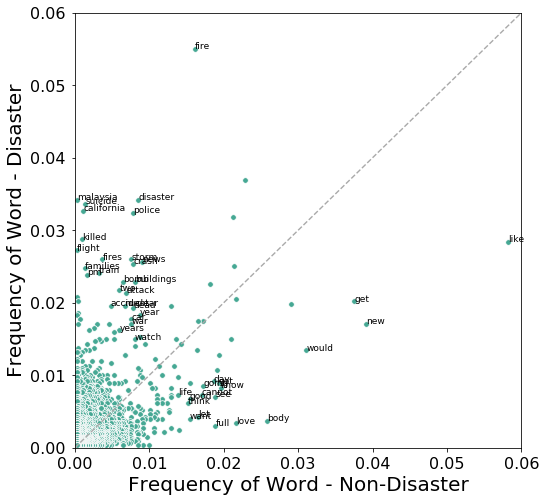

In [37]:
#import random 

fig, ax = plt.subplots(figsize=(8,8))

freq_20 = freq_df#[freq_df['freq'] >= 20]
freq_20 = freq_20[freq_20['word'] != 'xx90']

sns.scatterplot('0_freq_norm', '1_freq_norm', data=freq_20, ax=ax, color="#46A894")

ax.set_xlim(0, 0.06)
ax.set_ylim(0, 0.06)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="#AAAAAA")
ax.set_ylabel('Frequency of Word - Disaster', fontsize=SUBTITLE_SIZE)
ax.set_xlabel('Frequency of Word - Non-Disaster', fontsize=SUBTITLE_SIZE)
ax.tick_params(labelsize=TICK_SIZE)

for row in freq_20.iterrows():
    if row[1]['freq_norm'] >= 0.01 and abs(row[1]['diff %']) >= 0.3:
        ax.annotate(row[1]['word'], 
                    (row[1]['0_freq_norm'],# - random.random()*0.002,
                     row[1]['1_freq_norm']),# - random.random()*0.002), 
                    fontsize=9)

# Emoji usage in each class

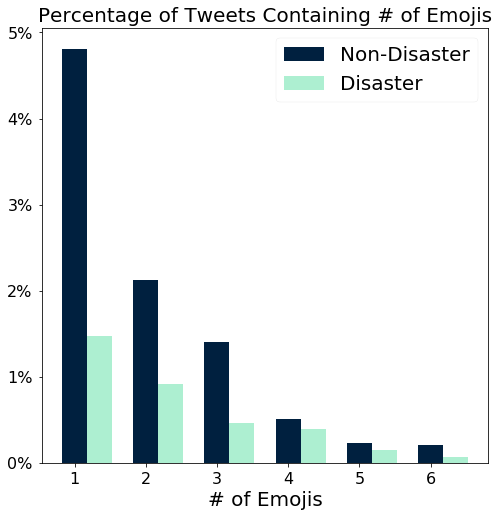

In [12]:
emoji_count_0 = []
emoji_count_1 = []

for i,x in enumerate(X):
    if y[i] == 0:
        emoji_count_0.append(x.count('xx90'))
    elif y[i] == 1:
        emoji_count_1.append(x.count('xx90'))

emoji_count_0 = Counter(emoji_count_0)
emoji_count_1 = Counter(emoji_count_1)

y_count = Counter(y)

emoji_count_0_prop = list({key: value / y_count[0] for key, value in emoji_count_0.items()}.items())
emoji_count_1_prop = list({key: value / y_count[1] for key, value in emoji_count_1.items()}.items())

emoji_count_0_prop.sort(key=lambda x: x[0])
emoji_count_1_prop.sort(key=lambda x: x[0])

emoji_count_0_prop = emoji_count_0_prop[1:7]
emoji_count_1_prop = emoji_count_1_prop[1:7]

emoji_count_0_propp = list(zip(*emoji_count_0_prop))
emoji_count_1_propp = list(zip(*emoji_count_1_prop))

fig3, ax = plt.subplots(figsize=(8,8))

width = 0.35 

ax.bar(emoji_count_0_propp[0], emoji_count_0_propp[1], width=width, color=COLOR_0)
ax.bar([x+width for x in emoji_count_1_propp[0]], emoji_count_1_propp[1], width=width, color=COLOR_1)

ax.set_title('Percentage of Tweets Containing # of Emojis', fontsize=SUBTITLE_SIZE)

ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))

ax.set_xlabel('# of Emojis', fontsize=SUBTITLE_SIZE)

ax.legend(labels=['Non-Disaster', 'Disaster'], fontsize=SUBTITLE_SIZE)

ax.tick_params(labelsize=TICK_SIZE)

# Number of Words / URLs

In [13]:
df = pd.DataFrame(zip(X,y), columns=['X', 'y'])
df['Num Words'] = df['X'].apply(len)
df['Contains URL'] = df['X'].apply(lambda x: len(re.findall('https?://t\.co', ' '.join(x))))

summary = df.groupby('y').mean()

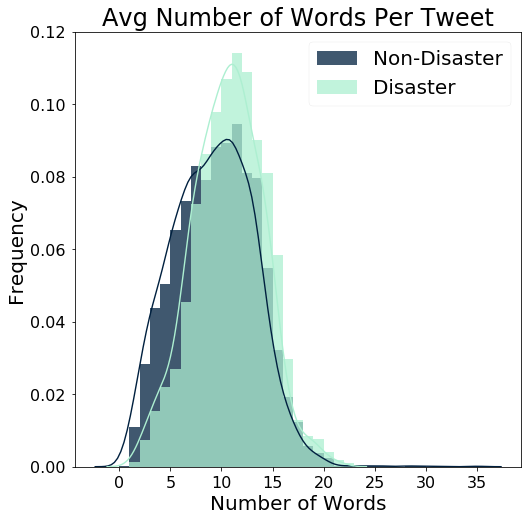

In [14]:
fig4, ax = plt.subplots(figsize=(8,8))

sns.distplot(df['Num Words'][df['y']==0], 
             bins=np.linspace(0, 30, 31), 
             color=COLOR_0, 
             ax=ax, 
             label='Non-Disaster',
             hist_kws={'alpha': 0.75})
sns.distplot(df['Num Words'][df['y']==1], 
             bins=np.linspace(0, 30, 31), 
             color=COLOR_1, 
             ax=ax, 
             label='Disaster',
             hist_kws={'alpha': 0.75})

ax.set_title('Avg Number of Words Per Tweet', fontsize=TITLE_SIZE)

ax.tick_params(labelsize=TICK_SIZE)

ax.set_xlabel('Number of Words', fontsize=SUBTITLE_SIZE)
ax.set_ylabel('Frequency', fontsize=SUBTITLE_SIZE)
ax.legend(fontsize=SUBTITLE_SIZE)

[Text(0, 0, 'Non-Disaster'), Text(0, 0, 'Disaster')]

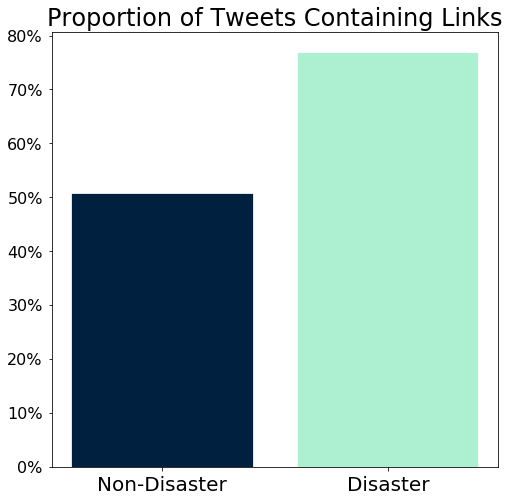

In [15]:
fig5, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(summary.index, summary['Contains URL'].values)
barlist[0].set_color(COLOR_0)
barlist[1].set_color(COLOR_1)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))
ax.set_title('Proportion of Tweets Containing Links', fontsize=TITLE_SIZE)

ax.tick_params(labelsize=TICK_SIZE)

ax.set_xticks([0,1])
ax.set_xticklabels(['Non-Disaster', 'Disaster'], fontsize=SUBTITLE_SIZE)

Tweets referring to disasters are slightly longer in length than other tweets, comprising of around 9.5 words on average compared with 8.5 words for the latter.

Disaster tweets also contains links to external webpages 13.0% of the time - significantly more frequent than other tweets at 8.4%.

# POS & Punctuation Analysis

In [16]:
_TRAIN_DATA_PATH = 'tfn/data/train.csv'

In [17]:
raw_data = pd.read_csv(_TRAIN_DATA_PATH, header=0)
X_raw = raw_data['text'].to_numpy()
y_raw = raw_data['target'].to_numpy()

In [18]:
en = spacy.load('en_core_web_sm')
lemmatize = en.Defaults.create_lemmatizer()

In [19]:
POS_LIST = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
            "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE"]            

punc = {0: Counter(), 1: Counter()}
pos = {0: Counter(), 1: Counter()}
for i, doc in enumerate(X_raw):
    punc[y[i]] += Counter([char for char in doc if char in string.punctuation])
    pos[y[i]] += Counter([token.pos_ for token in en(doc)])
    
punc['tot'] = punc[0] + punc[1]
pos['tot'] = pos[0] + pos[1]

for d in punc:
    punc[d] = dict(punc[d])
for d in pos:
    pos[d] = dict(pos[d])

for d in punc:
    for p in string.punctuation:
        if p not in punc[d]:
            punc[d][p] = 0
for d in pos:
    for p in POS_LIST:
        if p not in pos[d]:
            pos[d][p] = 0

In [20]:
punc_sorted = [(k,v/y_raw.shape[0]) for k,v in punc['tot'].items()]
punc_sorted.sort(key=lambda x: x[1], reverse=True)

pos_sorted = [(k,v/y_raw.shape[0]) for k,v in pos['tot'].items()]
pos_sorted.sort(key=lambda x: x[1], reverse=True)


punc_sorted_0 = [(k,v/y_raw[y_raw==0].shape[0]) for k,v in punc[0].items()]
punc_sorted_0.sort(key=lambda x: list(zip(*punc_sorted))[0].index(x[0]))

punc_sorted_1 = [(k,v/y_raw[y_raw==1].shape[0]) for k,v in punc[1].items()]
punc_sorted_1.sort(key=lambda x: list(zip(*punc_sorted))[0].index(x[0]))


pos_sorted_0 = [(k,v/y_raw[y_raw==0].shape[0]) for k,v in pos[0].items()]
pos_sorted_0.sort(key=lambda x: list(zip(*pos_sorted))[0].index(x[0]))

pos_sorted_1 = [(k,v/y_raw[y_raw==1].shape[0]) for k,v in pos[1].items()]
pos_sorted_1.sort(key=lambda x: list(zip(*pos_sorted))[0].index(x[0]))

In [21]:
punc['tot'].items()

dict_items([('.', 11696), ("'", 3157), (',', 2), ('#', 3403), ('=', 53), ('>', 1), ('-', 1753), (';', 587), (')', 373), ('!', 1173), ('?', 3126), ('@', 2759), (':', 6910), ('/', 14585), ('_', 863), ('&', 457), ('(', 349), ('[', 132), (']', 131), ('|', 152), ('+', 80), ('*', 179), ('%', 46), ('~', 37), ('$', 44), ('^', 6), ('\\', 5), ('`', 3), ('{', 3), ('}', 4), ('"', 0), ('<', 0)])

In [22]:
def diff_func(a,b):
    m = max(a,b)
    if m > 0:
        return (a - b)/max(a,b)
    else:
        return 0

Text(0.5, 1.0, 'Difference in Punctuation Usage Per Tweet Between Disaster and non-Disaster Tweets')

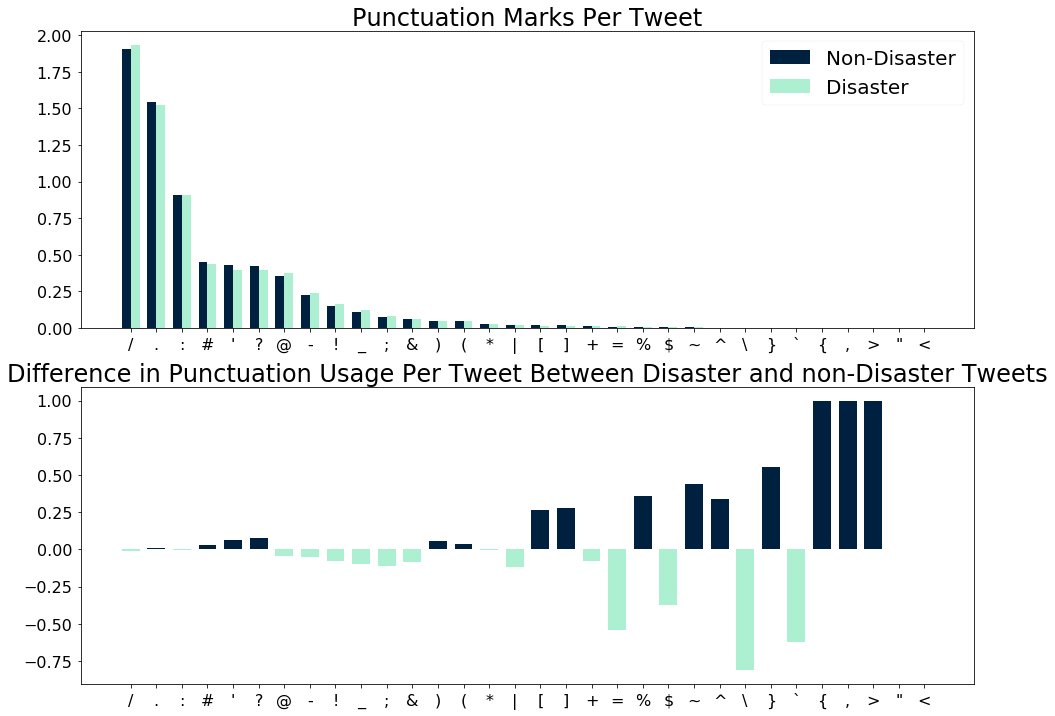

In [23]:
N = len(list(zip(*punc_sorted_0))[1])
ind = np.arange(N)
width = 0.35

fig6, ax = plt.subplots(2,1, figsize=(16,12))

ax[0].bar(ind, list(zip(*punc_sorted_0))[1], width, color=COLOR_0, label='Non-Disaster')
ax[0].bar(ind+width, list(zip(*punc_sorted_1))[1], width, color=COLOR_1, label='Disaster')

ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(list(zip(*punc_sorted_0))[0])

ax[0].legend(loc='best', fontsize=SUBTITLE_SIZE)

ax[0].tick_params(labelsize=TICK_SIZE)

ax[0].set_title('Punctuation Marks Per Tweet', fontsize=TITLE_SIZE)

color_0 = 'blue'
color_1 = 'orange'

N = len(list(zip(*punc_sorted_0))[1])
ind = np.arange(N)
width = 0.7

the_data = [diff_func(a,b) for a,b in zip(list(zip(*punc_sorted_0))[1],list(zip(*punc_sorted_1))[1])]

ax[1].bar(ind, the_data, width,
      color=[COLOR_0 if x > 0 else COLOR_1 for x in the_data])

ax[1].set_xticks(ind)
ax[1].set_xticklabels(list(zip(*punc_sorted_0))[0])

ax[1].tick_params(labelsize=TICK_SIZE)

ax[1].set_title('Difference in Punctuation Usage Per Tweet Between Disaster and non-Disaster Tweets', 
                fontsize=TITLE_SIZE)

Text(0.5, 1.0, 'Difference in POS Usage Per Tweet Between Disaster and non-Disaster Tweets')

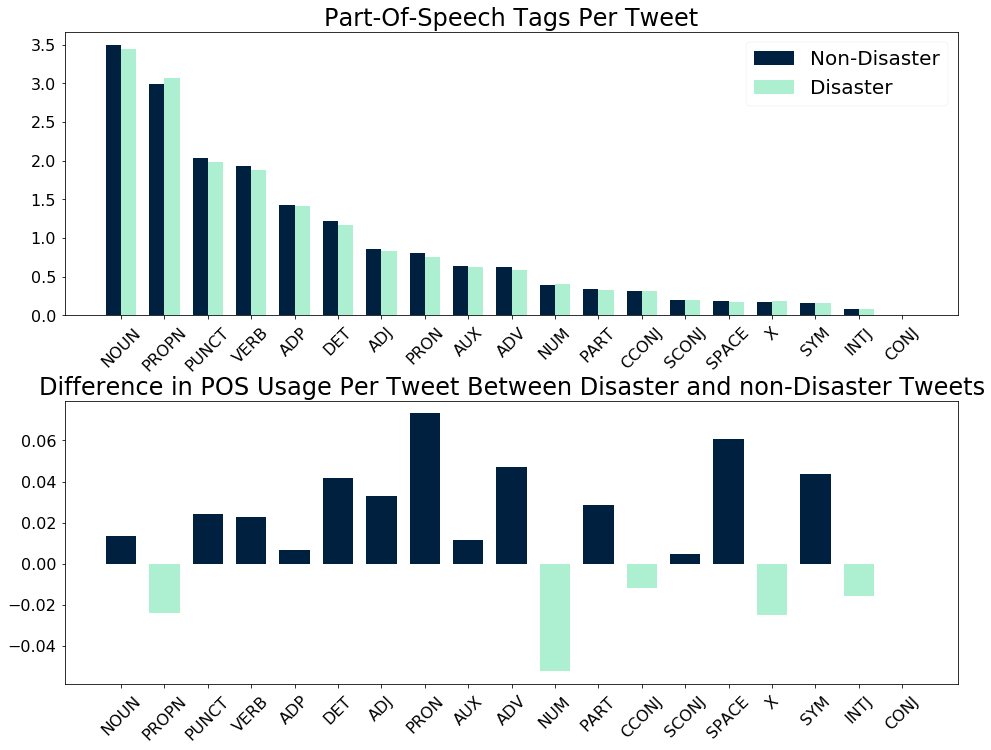

In [24]:
N = len(list(zip(*pos_sorted_0))[1])
ind = np.arange(N)
width = 0.35

fig7, ax = plt.subplots(2,1, figsize=(16,12))
# increase spacing between subplots to accommodate larger and rotated labels
plt.subplots_adjust(hspace = 0.3)

ax[0].bar(ind, list(zip(*pos_sorted_0))[1], width, color=COLOR_0, label='Non-Disaster')
ax[0].bar(ind+width, list(zip(*pos_sorted_1))[1], width, color=COLOR_1, label='Disaster')

ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(list(zip(*pos_sorted_0))[0])

for tick in ax[0].get_xticklabels(): 
    tick.set_rotation(45)

ax[0].legend(loc='best', fontsize=SUBTITLE_SIZE)

ax[0].tick_params(labelsize=TICK_SIZE)

ax[0].set_title('Part-Of-Speech Tags Per Tweet', fontsize=TITLE_SIZE)


N = len(list(zip(*pos_sorted_0))[1])
ind = np.arange(N)
width = 0.7

the_data = [diff_func(a,b) for a,b in zip(list(zip(*pos_sorted_0))[1],list(zip(*pos_sorted_1))[1])]

ax[1].bar(ind, the_data, width,
      color=[COLOR_0 if x > 0 else COLOR_1 for x in the_data])

ax[1].set_xticks(ind)
ax[1].set_xticklabels(list(zip(*pos_sorted_0))[0])

for tick in ax[1].get_xticklabels(): 
    tick.set_rotation(45)

ax[1].tick_params(labelsize=TICK_SIZE)

ax[1].set_title('Difference in POS Usage Per Tweet Between Disaster and non-Disaster Tweets', fontsize=TITLE_SIZE)

# Domain Analysis

In [25]:
_URL_DATA_PATH = 'tfn/data/url.csv'

In [26]:
url_data = pd.read_csv(_URL_DATA_PATH)

In [27]:
def get_domain(x):
    try:
        domain = urlparse.urlparse(x).netloc
        return domain.replace('www.', '').split(':')[0]
    except AttributeError:
        return None

url_data['domain'] = url_data['redirect_url'].apply(get_domain)

In [28]:
raw_data['twitter_urls'] = raw_data['text'].apply(lambda x: re.findall('https?://t.co/\w{10}', x))

rd2 = raw_data.explode('twitter_urls').dropna(subset=['twitter_urls'])

merged = pd.merge(rd2, url_data[['url', 'domain']], left_on='twitter_urls', right_on='url')

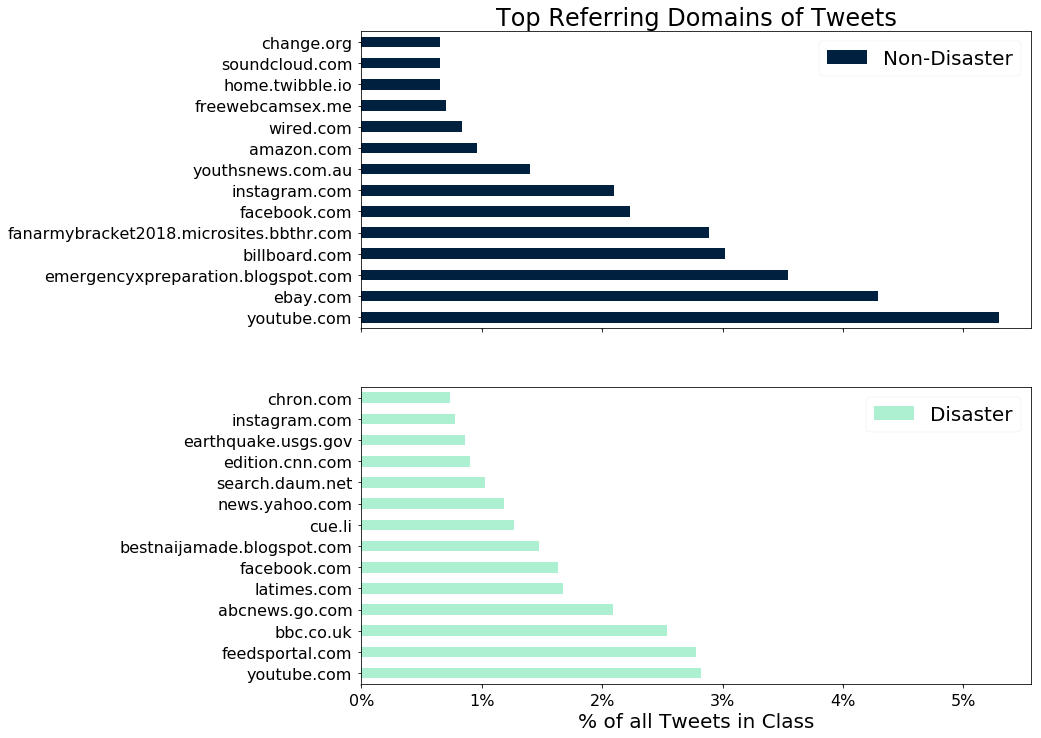

In [29]:
fig8, ax = plt.subplots(2,1, figsize=(12,12), sharex=True)

the_0s = merged['domain'][merged['target']==0]
the_1s = merged['domain'][merged['target']==1]

(the_0s.value_counts() / the_0s.count()).iloc[1:15].plot(kind='barh', color=COLOR_0, ax=ax[0], label='Non-Disaster')
(the_1s.value_counts() / the_1s.count()).iloc[1:15].plot(kind='barh', color=COLOR_1, ax=ax[1], label='Disaster')

ax[0].set_title('Top Referring Domains of Tweets', fontsize=TITLE_SIZE)
#ax[1].set_title('Top Referring Domains of Tweets', fontsize=TITLE_SIZE)

ax[0].get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))
ax[1].get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))
ax[0].tick_params(labelsize=TICK_SIZE)
ax[1].tick_params(labelsize=TICK_SIZE)

ax[1].set_xlabel('% of all Tweets in Class', fontsize=SUBTITLE_SIZE)

ax[0].legend(fontsize=SUBTITLE_SIZE)
ax[1].legend(fontsize=SUBTITLE_SIZE)

# Sentiment Analysis

In [30]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [31]:
raw_data['Textblob'] = raw_data['text'].apply(lambda x: TextBlob(x).sentiment)

raw_data['Sentiment (Textblob)'] = raw_data['Textblob'].apply(lambda x: x[0])
raw_data['Subjectivity (Textblob)'] = raw_data['Textblob'].apply(lambda x: x[1])

raw_data['Vader'] = raw_data['text'].apply(lambda x: analyser.polarity_scores(x))

raw_data['Sentiment_Neg (Vader)'] = raw_data['Vader'].apply(lambda x: x['neg'])
raw_data['Sentiment_Neu (Vader)'] = raw_data['Vader'].apply(lambda x: x['neu'])
raw_data['Sentiment_Pos (Vader)'] = raw_data['Vader'].apply(lambda x: x['pos'])
raw_data['Sentiment_Comp (Vader)'] = raw_data['Vader'].apply(lambda x: x['compound'])

Text(0.5, 1.0, 'Average Sentiment and Subjectivity of Disaster/Non-Disaster Tweets')

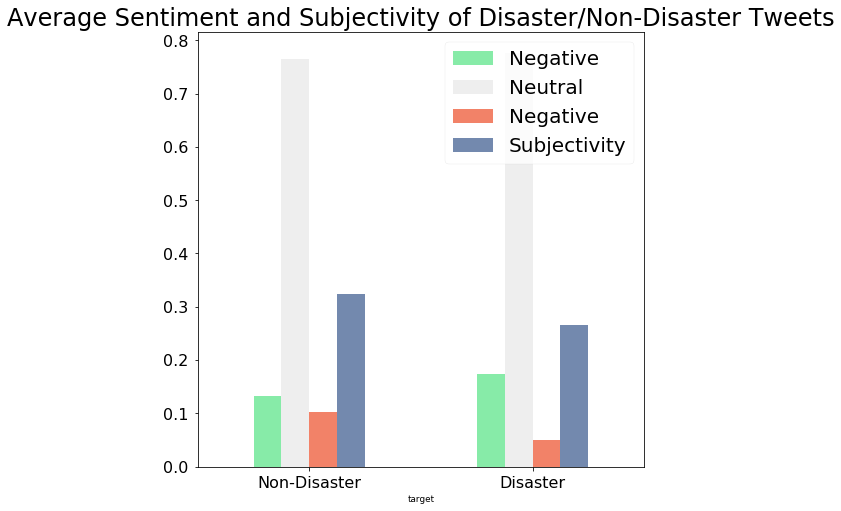

In [32]:
fig9, ax = plt.subplots(figsize=(8, 8))



raw_data[['Sentiment_Neg (Vader)', 'Sentiment_Neu (Vader)', 'Sentiment_Pos (Vader)', 'Subjectivity (Textblob)', 'target']] \
    .groupby('target') \
    .mean() \
    .plot(kind='bar', ax=ax, color=[COLOR_NEG, COLOR_NEU, COLOR_POS, COLOR_OTH])
ax.legend(labels=['Negative', 'Neutral', 'Negative', 'Subjectivity'], fontsize=SUBTITLE_SIZE)
ax.set_xticklabels(['Non-Disaster', 'Disaster'], fontsize=SUBTITLE_SIZE)
ax.tick_params(rotation=0, labelsize=TICK_SIZE)
ax.set_title('Average Sentiment and Subjectivity of Disaster/Non-Disaster Tweets', fontsize=TITLE_SIZE)

Text(0.5, 1.0, 'Distribution of Subjectivity Scores')

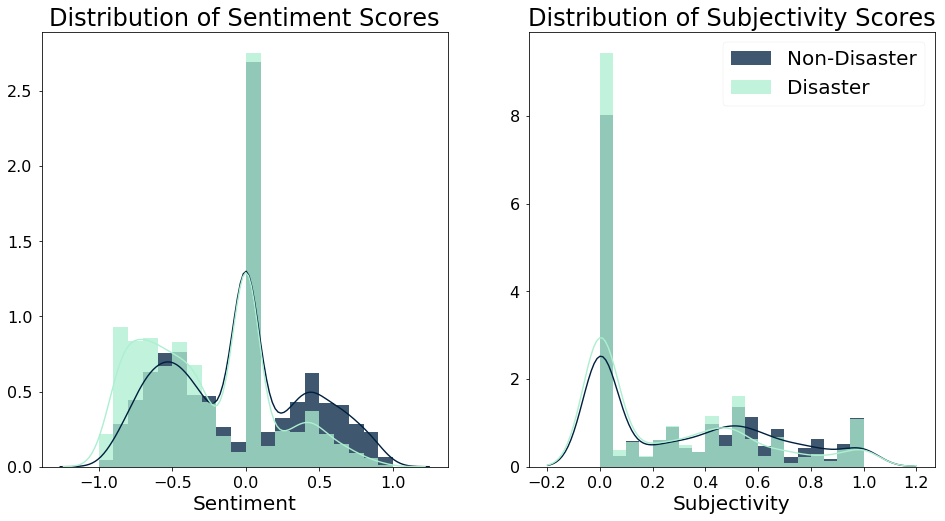

In [33]:
fig10, ax = plt.subplots(1,2, figsize=(16,8))

sns.distplot(raw_data['Sentiment_Comp (Vader)'][raw_data['target']==0], 
             bins=np.linspace(-1,1,21), 
             ax=ax[0], 
             color=COLOR_0,
             hist_kws={'alpha': 0.75})
sns.distplot(raw_data['Sentiment_Comp (Vader)'][raw_data['target']==1], 
             bins=np.linspace(-1,1,21),
             ax=ax[0], 
             color=COLOR_1,
             hist_kws={'alpha': 0.75})

ax[0].tick_params(labelsize=TICK_SIZE)
ax[0].set_xlabel('Sentiment',fontsize=SUBTITLE_SIZE)
ax[0].set_title('Distribution of Sentiment Scores',fontsize=TITLE_SIZE)

sns.distplot(raw_data['Subjectivity (Textblob)'][raw_data['target']==0], 
             bins=np.linspace(0,1,21), 
             ax=ax[1], 
             color=COLOR_0, 
             label='Non-Disaster',
             hist_kws={'alpha': 0.75})
sns.distplot(raw_data['Subjectivity (Textblob)'][raw_data['target']==1], 
             bins=np.linspace(0,1,21),
             ax=ax[1], 
             color=COLOR_1, 
             label='Disaster',
             hist_kws={'alpha': 0.75})
ax[1].legend(fontsize=SUBTITLE_SIZE)

ax[1].tick_params(labelsize=TICK_SIZE)
ax[1].set_xlabel('Subjectivity',fontsize=SUBTITLE_SIZE)
ax[1].set_title('Distribution of Subjectivity Scores',fontsize=TITLE_SIZE)

# Spell Check

In [34]:
df['SpellChecks'] = df['X'].apply(lambda x: check_spelling(x)[1])

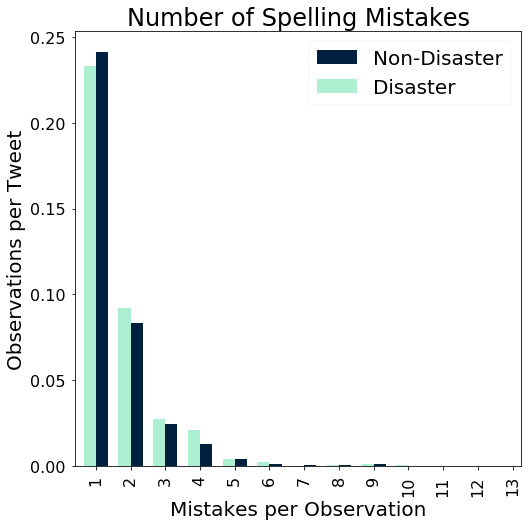

In [35]:
fig11, ax = plt.subplots(figsize=(8,8), sharey=True)

sc = df['SpellChecks'].value_counts()

sc0 = df['SpellChecks'][df['y']==0].value_counts()
sc0 = sc0.reindex(range(0, sc.index.max()+1), fill_value=0) / df[df['y']==0].shape[0]

sc1 = df['SpellChecks'][df['y']==1].value_counts()
sc1 = sc1.reindex(range(0, sc.index.max()+1), fill_value=0) / df[df['y']==1].shape[0]

sc0[1:].plot(kind='bar', ax=ax, color=COLOR_0, width=0.35, position=0, label='Non-Disaster')
sc1[1:].plot(kind='bar', ax=ax, color=COLOR_1, width=0.35, position=1, label='Disaster')

ax.tick_params(labelsize=TICK_SIZE)
ax.set_ylabel('Observations per Tweet', fontsize=SUBTITLE_SIZE)
ax.set_xlabel('Mistakes per Observation', fontsize=SUBTITLE_SIZE)

ax.set_title('Number of Spelling Mistakes', fontsize=TITLE_SIZE)
ax.legend(fontsize=SUBTITLE_SIZE)

In [36]:
fig1.savefig('figures/class_proportion')
fig2.savefig('figures/word_freq')
fig3.savefig('figures/emoji_freq')
fig4.savefig('figures/num_words')
fig5.savefig('figures/contain_links')
fig6.savefig('figures/punctuation')
fig7.savefig('figures/part_of_speech')
fig8.savefig('figures/domain_freq')
fig9.savefig('figures/sent_sub_bar')
fig10.savefig('figures/sent_sub_dist')
fig11.savefig('figures/spelling_mistakes')